In [ ]:
# tf import should be placed befor the pip install;
# otherwise, the following error occurs:
# module 'google.protobuf.descriptor' has no attribute '_internal_create_key'
import tensorflow as tf
from tensorflow import keras

!apt update && apt install -y xvfb
!pip install -q -U tf-agents pyvirtualdisplay gym[Box2D]

# Common imports
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# np.random.seed(42)
# tf.random.set_seed(42)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Ign:13 https://developer.download.nvidia.com/comp

# Etude 1 - Using Policy Gradients to Solve Lunar Lander

Let's use policy gradients to solve OpenAI Gym’s LunarLander-v2 environment.

In [ ]:
import gym
import pyvirtualdisplay

In [ ]:
env_lander = gym.make('LunarLander-v2')

Let's create a function for drawing an environment, and then let's draw the environment.

In [ ]:
def draw_environment(env, figsize=(7,5)):
    """Draws the environment."""
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")    

 Let's run the pyvirtualdisplay Python library that wraps Xvfb so that we can render the environment, and then let's look at the environment.

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

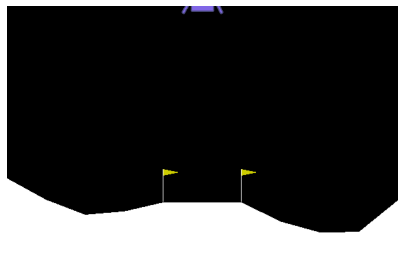

In [ ]:
draw_environment(env_lander)

Let's look at the observation.

In [ ]:
obs = env_lander.reset()

In [ ]:
obs

array([ 0.00216055,  1.416843  ,  0.21882105,  0.26323718, -0.00249671,
       -0.04956623,  0.        ,  0.        ], dtype=float32)

The observations consists of eight components:
* obs[0] is the horizontal coordinate
* obs[1] is the vertical coordinate
* obs[2] is the horizontal speed
* obs[3] is the vertical speed
* obs[4] is the angle
* obs[5] is the angular speed
* obs[6] 1 if first leg has contact, else 0
* obs[7] 1 if second leg has contact, else 0


 Let's look at the actions.

In [ ]:
env_lander.action_space

Discrete(4)

There are four actions available:
1.   Do nothing
2.   Fire left orientation engine
3.   Fire main engine
4.   Fire right orientation engine 

All actions are descrete. Now let's try to pass the action to the environment and see the result.



In [ ]:
obs, reward, done, info = env_lander.step(0)

In [ ]:
print(f'Observation: {obs}')
print(f'Reward: {reward}')
print(f'Done: {done}')

Observation: [ 0.004321    1.4221879   0.21852522  0.2375389  -0.00494592 -0.04898799
  0.          0.        ]
Reward: 1.1745359337467676
Done: False


Let' create a deep policy network. It should have eight inputs (for each observation) and four outputs (for each possible action). In the output layer, we will use the softmax activation function that will return the probability of the actions to take.

In [ ]:
policy_lander = keras.models.Sequential([
    keras.layers.Dense(64, input_shape=[len(obs)], activation='relu'),
    keras.layers.Dense(64, activation='relu'),    
    keras.layers.Dense(4, activation='softmax') 
])

Now let's define the functions that compute the exponentially discounted rewards and normalize them. Rewards for past steps are discounted more than for recent steps.

In [ ]:
def discount_rewards(rewards, discount_rate):
    """"Calculates discounted rewards."""
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return tf.cast(discounted, dtype=tf.float32)

In [ ]:
def normalize_rewards(rewards_batch):
    """"Normalizes (standardizes, to be precise) rewards."""
    #unfolds the list of lists
    rewards = np.concatenate(rewards_batch).ravel()
    
    # performs standardization
    rewards -= np.mean(rewards) 
    rewards /= np.std(rewards)
    return rewards

Now let's create the training loop. In each iteration, we will collect the batch of episodes. In each episode, we will collect actions, observations, and rewards. After playing the specified number of episodes, we will have the batches of actions, observations, and rewards, and we will normalize (standardize) the batch of rewards.
Then we will create a loss function. We will use a sparse cross-entropy between the predicted and taken action (note that the actual action is sampled from the softmax probabilities returned by the NN), weighted by the normalized discounted rewards.

In [ ]:
NUM_EPISODES_BATCH = 20
ITERATIONS = 100
optimizer = keras.optimizers.Adam(learning_rate=0.003)

# accumulates all episode rewards
score = []

for i in range(ITERATIONS):
    print(f"Batch {i + 1}/{ITERATIONS}")
    start = time.time()
    
    rewards_batch = []
    observations_batch = []
    actions_batch = []
    rewards_episode = []
    
    for i in range(NUM_EPISODES_BATCH):
        curr_observation = env_lander.reset()
        done = False
        transitions = []
        
        while not done:
            # predicting the action probabilities
            action_probs = policy_lander.predict(tf.expand_dims(curr_observation, 0))

            # sampling an action from the predicted probabilities            
            action = tf.squeeze(tf.random.categorical(action_probs, 1))

            prev_observation = curr_observation
            
            # getting a new observation and reward
            curr_observation, reward, done, info = env_lander.step(action.numpy())

            # saving the observation, the action taken, and the reward obtained
            transitions.append((prev_observation, action, reward))

        # saving separately rewards
        rewards = [reward for (observation, action, reward) in transitions]
        
        # discounting episode rewards
        discounted_rwds = discount_rewards(rewards, 0.99)
        
        rewards_batch.append(discounted_rwds)
        rewards_episode.append(tf.reduce_sum(rewards))

        # saving observations
        observations = [observation for (observation, action, reward) in transitions]
        observations_batch.append(observations)

        # saving actions
        actions = [action for (observation, action, reward) in transitions]
        actions_batch.append(actions)

        score.append(np.sum(rewards))
        print(f"        [{i+1}] Rewards : {round(np.sum(rewards))}")
    
    # displaying the mean batch rewards
    print(f"    Mean Batch Rewards: {tf.math.round(tf.reduce_mean(rewards_episode))}")

    # normalizing rewards and flattening batches that are lists of lists
    rewards_batch_normalized = normalize_rewards(rewards_batch)
    actions_batch = sum(actions_batch, [])
    observations_batch = np.array(sum(observations_batch, []))
        
    with tf.GradientTape() as tape:
        pred_probs = policy_lander(observations_batch)
              
        # loss function
        negative_likelihoods = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions_batch, logits=pred_probs)
        weighted_negative_likelihoods = tf.multiply(negative_likelihoods, tf.stop_gradient(rewards_batch_normalized))        
        loss = tf.reduce_mean(weighted_negative_likelihoods)      
     
    grads = tape.gradient(loss, policy_lander.trainable_variables)
    optimizer.apply_gradients(zip(grads, policy_lander.trainable_variables))
    print(f'    Time (sec): {round(time.time()-start)}')

Batch 1/100
        [1] Rewards : -206.0
        [2] Rewards : -154.0
        [3] Rewards : -52.0
        [4] Rewards : -133.0
        [5] Rewards : -197.0
        [6] Rewards : -92.0
        [7] Rewards : -77.0
        [8] Rewards : -276.0
        [9] Rewards : -114.0
        [10] Rewards : -236.0
        [11] Rewards : -159.0
        [12] Rewards : -174.0
        [13] Rewards : -289.0
        [14] Rewards : -72.0
        [15] Rewards : -355.0
        [16] Rewards : -285.0
        [17] Rewards : -339.0
        [18] Rewards : -87.0
        [19] Rewards : -334.0
        [20] Rewards : -233.0
    Mean Batch Rewards: -193.0
    Time (sec): 50
Batch 2/100
        [1] Rewards : -199.0
        [2] Rewards : -407.0
        [3] Rewards : -341.0
        [4] Rewards : -223.0
        [5] Rewards : -131.0
        [6] Rewards : -101.0
        [7] Rewards : -141.0
        [8] Rewards : -123.0
        [9] Rewards : -161.0
        [10] Rewards : -102.0
        [11] Rewards : -226.0
        [12] Reward

In [ ]:
def moving_average(x, w=10):
    """Calculates the moving average."""
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
score = np.array(score)
avg_score = moving_average(score, 50)

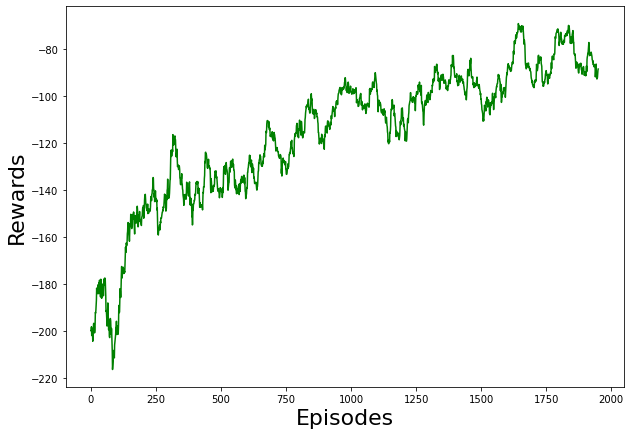

In [ ]:
plt.figure(figsize=(10,7))
plt.ylabel("Rewards",fontsize=22)
plt.xlabel("Episodes",fontsize=22)
plt.plot(avg_score, color='green')

Generally, the Lunar Lander game is not easy to solve using the REINFORCE algorithm. In our case, the tranining took about an hour, and we could only archieve the average reward of -80. Some authors used hundreds of batches of 1000 episodes, or used smaller batches but made 10k-15k iterations.

# Etude 2 - Using TF-Agents to Solve Space Invaders

Use TF-Agents to train an agent that can achieve a superhuman level at SpaceInvaders-v4 using any of the available algorithms.

## Environment

First we start with loading the SpaceInvaders-V4 environment. Let's import the `suite_gym` environment wrapper. Alternatively, we can import the `suite_atari` wrapper that by default automatically applies AtariPreprocessing; however, since we also need to apply the frame stacking, we end up specifying the same wrappers as when using the `suite_gym`.

In [ ]:
from tf_agents.environments import suite_gym
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4
from tf_agents.environments.tf_py_environment import TFPyEnvironment

Now we load the environment and apply the preprocessing steps. Note that the default Atari environment already applies some preprocessing (random frame skipping and
max pooling), therefore we load the raw, nonskipping variant.

In [ ]:
env_si = suite_gym.load("SpaceInvadersNoFrameskip-v4", gym_env_wrappers=[AtariPreprocessing, FrameStack4])

Actions, observations and timesteps have the following structure:

In [ ]:
env_si.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)

In [ ]:
# note that the observations were downsampled to 84x84 pixels, 4 frames
env_si.observation_spec()

BoundedArraySpec(shape=(84, 84, 4), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [ ]:
env_si.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(84, 84, 4), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

Let's see what each action does.

In [ ]:
env_si.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

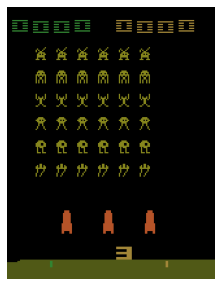

In [ ]:
draw_environment(env_si)

For performance reasons, let's convert the Python environment to the TF environment.

In [ ]:
env_si = TFPyEnvironment(env_si)

## Agent

Let's first use the standard DQN agent. To do this, let's create a Q-Network. The preprocessing layer will normalize the image and cast it to float32 to save space in the replay buffer. 

In [ ]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    env_si.observation_spec(),
    env_si.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

Then let's create the agent.

In [ ]:
from tf_agents.agents import DqnAgent
from tf_agents.utils import common

First, we will need the optimizer. To improve the result, we will also use the decaying epsilon value; for this purpose, we can just use PolynomialDecay from tf.optimizers.schedules.

In [ ]:
# train step counter
train_step = tf.Variable(0) 

# a training step runs every 4 collect steps (that is, 16 )
UPDATE_PERIOD = 4

optimizer = tf.optimizers.Adam()
epsilon_decay = tf.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 1.0,
    decay_steps = 250000,
    end_learning_rate = 0.01
)

agent = DqnAgent(
    env_si.time_step_spec(),
    env_si.action_spec(),
    q_net,
    optimizer=optimizer,
    target_update_period=2000, # update frequency of the target network
    epsilon_greedy=lambda:epsilon_decay(train_step), # we need lambda to pass the function
    gamma = 0.99,
    td_errors_loss_fn=common.element_wise_huber_loss, # to return the error per instance, not the mean
    train_step_counter=train_step,
)
agent.initialize()

## Metrics

Now we add some metrics.


In [ ]:
from tf_agents.metrics import tf_metrics

In [ ]:
si_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

We will also add the metrics logging.

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging

# output sample
logging.getLogger().setLevel(logging.INFO)

log_metrics(si_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


## Replay Buffer

Let's create the replay buffer that will keep track of data collected from the environment. We will use the buffer with samples that can be sampled uniformly.

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

REPLAY_BUFFER_CAPACITY = 250000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env_si.batch_size, # we have batch size of 1
    max_length=REPLAY_BUFFER_CAPACITY)

Besides, we need to create an observer that saves to the replay buffer.

In [ ]:
replay_observer = replay_buffer.add_batch

## Data Collection

Now let's create the dynamic driver that will collect trajectories for the specified number of steps. To make training faster, we will also create a random policy that we will initially use to collect the trajectories for a small number of steps, and then we will switch to the agent's collect (greedy) policy.

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(env_si.time_step_spec(),
                                        env_si.action_spec())

In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

# random policy driver
init_step_driver = DynamicStepDriver(
    env_si,
    initial_collect_policy,
    observers=[replay_observer],
    num_steps=20000) # 80000 frames

# run the driver to fill the replay buffer
init_step_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


(TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 84, 84, 4), dtype=uint8, numpy=
array([[[[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        ...,

        [[79, 79, 79, 79],
         [79, 79, 79, 79],
         [79, 79, 79, 79],
         ...,
         [79, 79, 79, 79],
         [7

Let's see what was saved to the replay buffer:

In [ ]:
trajectories, add_info = replay_buffer.get_next()
trajectories.observation.shape

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


TensorShape([84, 84, 4])

Now let's create the main driver that would collect trajectories using the agent's policy. We will collect 4 steps for each training iteration.

In [ ]:
# agent's policy driver
collect_step_driver = DynamicStepDriver(
    env_si,
    agent.collect_policy,
    # putting si_metrics inside the brackets causes an error for some reason
    observers=[replay_observer] + si_metrics, 
    num_steps=UPDATE_PERIOD)

Now let's create a dataset from the replay buffer.

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

To improve performance, let's convert the `collect step driver` and the agent's train functions to TF functions.

In [ ]:
from tf_agents.utils.common import function

collect_step_driver.run = function(collect_step_driver.run)
agent.train = function(agent.train)

## Training

Now let's create the training loop.

In [ ]:
def train_agent(num_iter):
    """"Trains the agent for the specified number of iterations."""
    average_return = []
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(env_si.batch_size)
    iterator = iter(dataset)    
    for iteration in range(num_iter):
        time_step, policy_state = collect_step_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        
        average_return.append(si_metrics[2].result().numpy())
        print(f"\rIteration #: {iteration} ", end="") # end= prints on the same line
        
        if iteration % 1000 == 0:
            log_metrics(si_metrics) 
    return average_return       

In [ ]:
# actually requires much more steps to learn
avr_return = train_agent(15000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


Iteration #: 993 

INFO:absl: 
		 NumberOfEpisodes = 9
		 EnvironmentSteps = 4004
		 AverageReturn = 126.11111450195312
		 AverageEpisodeLength = 389.77777099609375


Iteration #: 1993 

INFO:absl: 
		 NumberOfEpisodes = 16
		 EnvironmentSteps = 8004
		 AverageReturn = 146.0
		 AverageEpisodeLength = 546.5


Iteration #: 2994 

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 12004
		 AverageReturn = 105.0
		 AverageEpisodeLength = 506.8999938964844


Iteration #: 3994 

INFO:absl: 
		 NumberOfEpisodes = 31
		 EnvironmentSteps = 16004
		 AverageReturn = 188.0
		 AverageEpisodeLength = 540.0999755859375


Iteration #: 4993 

INFO:absl: 
		 NumberOfEpisodes = 37
		 EnvironmentSteps = 20004
		 AverageReturn = 178.0
		 AverageEpisodeLength = 585.0999755859375


Iteration #: 5993 

INFO:absl: 
		 NumberOfEpisodes = 42
		 EnvironmentSteps = 24004
		 AverageReturn = 251.0
		 AverageEpisodeLength = 709.9000244140625


Iteration #: 6992 

INFO:absl: 
		 NumberOfEpisodes = 49
		 EnvironmentSteps = 28004
		 AverageReturn = 210.5
		 AverageEpisodeLength = 597.7000122070312


Iteration #: 7997 

INFO:absl: 
		 NumberOfEpisodes = 57
		 EnvironmentSteps = 32004
		 AverageReturn = 193.5
		 AverageEpisodeLength = 485.20001220703125


Iteration #: 8993 

INFO:absl: 
		 NumberOfEpisodes = 65
		 EnvironmentSteps = 36004
		 AverageReturn = 126.0
		 AverageEpisodeLength = 524.5


Iteration #: 9995 

INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 40004
		 AverageReturn = 152.0
		 AverageEpisodeLength = 484.1000061035156


Iteration #: 10994 

INFO:absl: 
		 NumberOfEpisodes = 81
		 EnvironmentSteps = 44004
		 AverageReturn = 174.0
		 AverageEpisodeLength = 528.0


Iteration #: 11998 

INFO:absl: 
		 NumberOfEpisodes = 90
		 EnvironmentSteps = 48004
		 AverageReturn = 138.0
		 AverageEpisodeLength = 487.70001220703125


Iteration #: 12998 

INFO:absl: 
		 NumberOfEpisodes = 98
		 EnvironmentSteps = 52004
		 AverageReturn = 156.0
		 AverageEpisodeLength = 517.7000122070312


Iteration #: 13996 

INFO:absl: 
		 NumberOfEpisodes = 107
		 EnvironmentSteps = 56004
		 AverageReturn = 145.5
		 AverageEpisodeLength = 468.20001220703125


Iteration #: 14999 

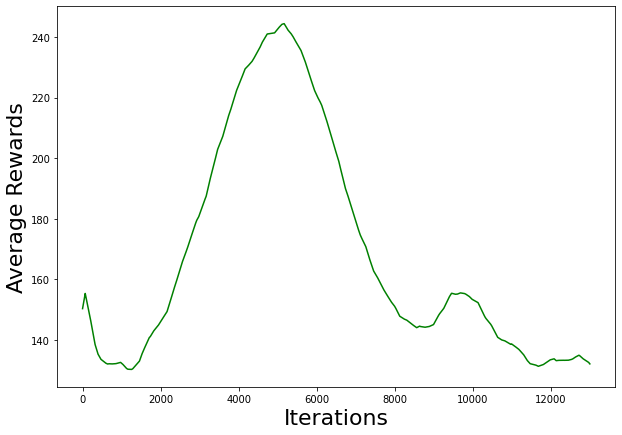

In [ ]:
plt.figure(figsize=(10,7))
plt.ylabel("Average Rewards",fontsize=22)
plt.xlabel("Iterations",fontsize=22)
plt.plot(moving_average(avr_return, 2000), color='green')

Looks like the model experienced the catastrophic forgetting.